<a href="https://colab.research.google.com/github/pachterlab/CWGFLHGCCHAP_2021/blob/master/notebooks/Revision/gastroGeneModuleAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Download Data**

In [1]:
import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

In [2]:
#Kallisto bus clustered starvation data, h5ad
download_file('10.22002/D1.1796','.gz')

#Starvation h5ad data, all nonzero genes included, filtered for 'real cells' from de-multiplexing
download_file('10.22002/D1.1797','.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1797.gz'

In [3]:
#Human ortholog annotations
download_file('10.22002/D1.1819','.gz')

#Panther annotations
download_file('10.22002/D1.1820','.gz')

#GO Terms
download_file('10.22002/D1.1822','.gz')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1822.gz'

In [4]:
!gunzip *.gz

In [5]:
#Install packages
!pip install --quiet anndata
!pip install --quiet scanpy==1.6.0

!pip install --quiet louvain

     |████████████████████████████████| 133kB 4.0MB/s 
     |████████████████████████████████| 7.7MB 3.9MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 1.2MB 37.8MB/s 
     |████████████████████████████████| 2.2MB 4.0MB/s 
     |████████████████████████████████| 3.2MB 38.0MB/s 


In [6]:
!pip3 install --quiet rpy2

###**Import Packages** 

In [7]:
#Import Packages

import random
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import (KNeighborsClassifier,NeighborhoodComponentsAnalysis)
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

#import scrublet as scr

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

import seaborn as sns
sns.set(style="whitegrid")
%load_ext rpy2.ipython

In [8]:
#Read in annotations
from io import StringIO

hg_ortho_df = pd.read_csv(StringIO(''.join(l.replace('|', '\t') for l in open('D1.1819'))),
            sep="\t",header=None,skiprows=[0,1,2,3])

hg_ortho_df[['XLOC','TCONS']] = hg_ortho_df[13].str.split(expand=True) 
hg_ortho_df[['Gene','gi']] = hg_ortho_df[3].str.split(expand=True) 
hg_ortho_df['Description']= hg_ortho_df[11]


panther_df = pd.read_csv('D1.1820',
            sep="\t",header=None) #skiprows=[0,1,2,3]



goTerm_df = pd.read_csv('D1.1822',
            sep=" ",header=None) #skiprows=[0,1,2,3]

In [9]:
#Read in saved data
bus_fs_combo = anndata.read('D1.1796')
print(bus_fs_combo)

bus_fs_raw  = anndata.read('D1.1797')
bus_fs_raw.obs['cellRanger_louvain'] = pd.Categorical(bus_fs_combo.obs['cellRanger_louvain'])
bus_fs_raw.obs['fed'] = pd.Categorical(bus_fs_combo.obs['fed'])
bus_fs_raw.obs['orgID'] = pd.Categorical(bus_fs_combo.obs['orgID'])
bus_fs_raw.obs['annos'] = pd.Categorical(bus_fs_combo.obs['annos'])
bus_fs_raw.obs['annosSub'] = pd.Categorical(bus_fs_combo.obs['annosSub'])

bus_fs_raw.uns['annos_colors'] = bus_fs_combo.uns['annos_colors']
bus_fs_raw.uns['cellRanger_louvain_colors'] = bus_fs_combo.uns['annosSub_colors']
#bus_fs_raw.uns['annosSub_colors'] = bus_fs_combo.uns['annosSub_colors']
print(bus_fs_raw)


AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'annos', 'new_cellRanger_louvain', 'annosSub'
    var: 'n_counts', 'mean', 'std'
    uns: 'annosSub_colors', 'annos_colors', 'cellRanger_louvain_colors', 'cellRanger_louvain_sizes', "dendrogram_['new_cellRanger_louvain']", 'dendrogram_new_cellRanger_louvain', 'fed_colors', 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'new_cellRanger_louvain_colors', 'orgID_colors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_nca', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub'
    uns: 'annos_colors', 'cellRanger_louvain_colors'


In [10]:
#Make dataframe, with 100 marker genes for each cluster + annotations
def annotateResDF(resultDF):
  orthoGene = []
  orthoDescr = []

  pantherNum = []
  pantherDescr = []

  goTerms = []

  genes = resultDF.Genes

  for g in genes:
          
    sub_df = hg_ortho_df[hg_ortho_df.XLOC.isin([g])]
    panth_df = panther_df[panther_df[0].isin([g])]
    go_df = goTerm_df[goTerm_df[0].isin([g])]

    if len(sub_df) > 0:
      #Save first result for gene/description
      orthoGene += [list(sub_df.Gene)[0]]
      orthoDescr += [list(sub_df.Description)[0]]
    else:
      orthoGene += ['NA']
      orthoDescr += ['NA']


    if len(panth_df) > 0:
      pantherNum += [list(panth_df[1])]
      pantherDescr += [list(panth_df[2])]
    else:
      pantherNum += ['NA']
      pantherDescr += ['NA']


    if len(go_df) > 0:
      goTerms += [list(go_df[1])]
    else:
      goTerms += ['NA']
  

  resultDF['orthoGene'] = orthoGene
  resultDF['orthoDescr'] = orthoDescr

  resultDF['pantherID'] = pantherNum
  resultDF['pantherDescr'] = pantherDescr

  resultDF['goTerms'] = goTerms
      
  return resultDF
  #list(neurons.uns['rank_genes_groups']['names']['1'])

### **Gastroderm Cell Type Gene Modules**

In [ ]:
#Gastroderm: 

gastro = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([3,7,14,15,19,24])]
gastro_copy = gastro.copy()

#Normalize and scale data
sc.pp.filter_genes(gastro_copy, min_counts=0)
sc.pp.filter_cells(gastro_copy, min_counts=0)

sc.pp.normalize_per_cell(gastro_copy, counts_per_cell_after=1e4)
gastro_copy.raw = sc.pp.log1p(gastro_copy, copy=True)

sc.pp.scale(gastro_copy, max_value=10)

sc.pp.highly_variable_genes(gastro_copy,n_top_genes=10000)
gastro_copy = gastro_copy[:,gastro_copy.var['highly_variable']]
gastro_copy

#gastro = gastro[:,gastro_copy.var_names]

View of AnnData object with n_obs × n_vars = 2564 × 10000
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'n_counts'
    var: 'n_counts', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annos_colors', 'cellRanger_louvain_colors', 'hvg'

In [ ]:
gastro = gastro[:,bus_fs_combo.var_names]

In [ ]:
gastro

View of AnnData object with n_obs × n_vars = 2564 × 8696
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub'
    uns: 'annos_colors', 'cellRanger_louvain_colors'

In [ ]:
#Transpose cellxgene
g_mod = anndata.AnnData(X=gastro.X.T)
g_mod.var_names = gastro.obs_names
g_mod.obs_names = gastro.var_names

print(g_mod)

g_copy = g_mod.copy()

AnnData object with n_obs × n_vars = 8696 × 2564


In [ ]:
#Scale and select top variable genes

#Normalize and scale data
sc.pp.filter_genes(g_copy, min_counts=0)

#sc.pp.normalize_per_cell(g_copy, counts_per_cell_after=1e4)
sc.pp.log1p(g_copy)

sc.pp.scale(g_copy, max_value=10)
sc.tl.pca(g_copy, n_comps=60,random_state=42)
#sc.pl.pca_variance_ratio(bus_combo, log=True)

#Determine neighbors for clustering
sc.pp.neighbors(g_copy,n_neighbors=15, n_pcs=15) #n_neighbors=5, n_pcs=15,  20, n_pcs=15
sc.tl.louvain(g_copy, resolution=4)



In [ ]:
# sc.tl.tsne(g_copy, n_pcs=15,random_state=42)
# sc.pl.tsne(g_copy,color=['louvain'])


In [ ]:
clusters = np.unique(g_copy.obs['louvain'])

In [ ]:
#Louvain clustering on genes across cells

genes = []
cluster = []
for c in clusters:
  sub = g_copy[g_copy.obs['louvain'] == c]
  genes += list(sub.obs_names)
  cluster += [c]*len(sub.obs_names)

genesDF = pd.DataFrame()
genesDF["Genes"] = genes
genesDF["Cluster"] = cluster

genesDF = annotateResDF(genesDF)
genesDF.head()

,Genes,Cluster,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms
0,XLOC_000079,0,PDIA6,protein disulfide-isomerase A6 isoform a [Hom...,[PTHR45815:SF3],[PROTEIN DISULFIDE-ISOMERASE A6],"[GO:0044238,GO:0006457,GO:0016853,GO:0019538,G..."
1,XLOC_000112,0,NA,NA,[PTHR23050:SF414],[CALMODULIN],"[GO:0019722,GO:0009987,GO:0007165,GO:0006928,G..."
2,XLOC_000338,0,NA,NA,[PTHR35263],[TESTIS-EXPRESSED PROTEIN 49],[nan]
3,XLOC_000296,0,HSD17B12,estradiol 17-beta-dehydrogenase 12 [Homo sapi...,[PTHR43899:SF13],[RH59310P],"[GO:0044238,GO:0006629,GO:0003824,GO:0008152,G..."
4,XLOC_000404,0,BLOC1S6,biogenesis of lysosome-related organelles com...,[PTHR31328],[BIOGENESIS OF LYSOSOME-RELATED ORGANELLES COM...,"[GO:0005737,GO:0043234,GO:0006810,GO:0032991,G..."


In [ ]:
genesDF.to_csv('gastroModules.csv',index=None)

In [ ]:
#Plot heatmap of average expression for each gene module in each cell type
modExpr = pd.DataFrame()
module = []
c_type = []
expr = []

cell_types = np.unique(gastro.obs['cellRanger_louvain'])
for i in clusters:
  #Get list of genes
  sub = g_copy[g_copy.obs['louvain'] == i]
  genes = list(sub.obs_names)

  for j in cell_types:
  #Filter cells and genes
    sub_g = gastro[gastro.obs['cellRanger_louvain'] == j]
    sub_g = sub_g[:,genes]
    expr += [np.log1p(np.sum(sub_g.X))]

    c_type += [j]
    module += [i]

modExpr['module'] = module
modExpr['type'] = c_type
modExpr['expr'] = expr


modExpr.head()
modExpr = modExpr.pivot("module", "type", "expr")

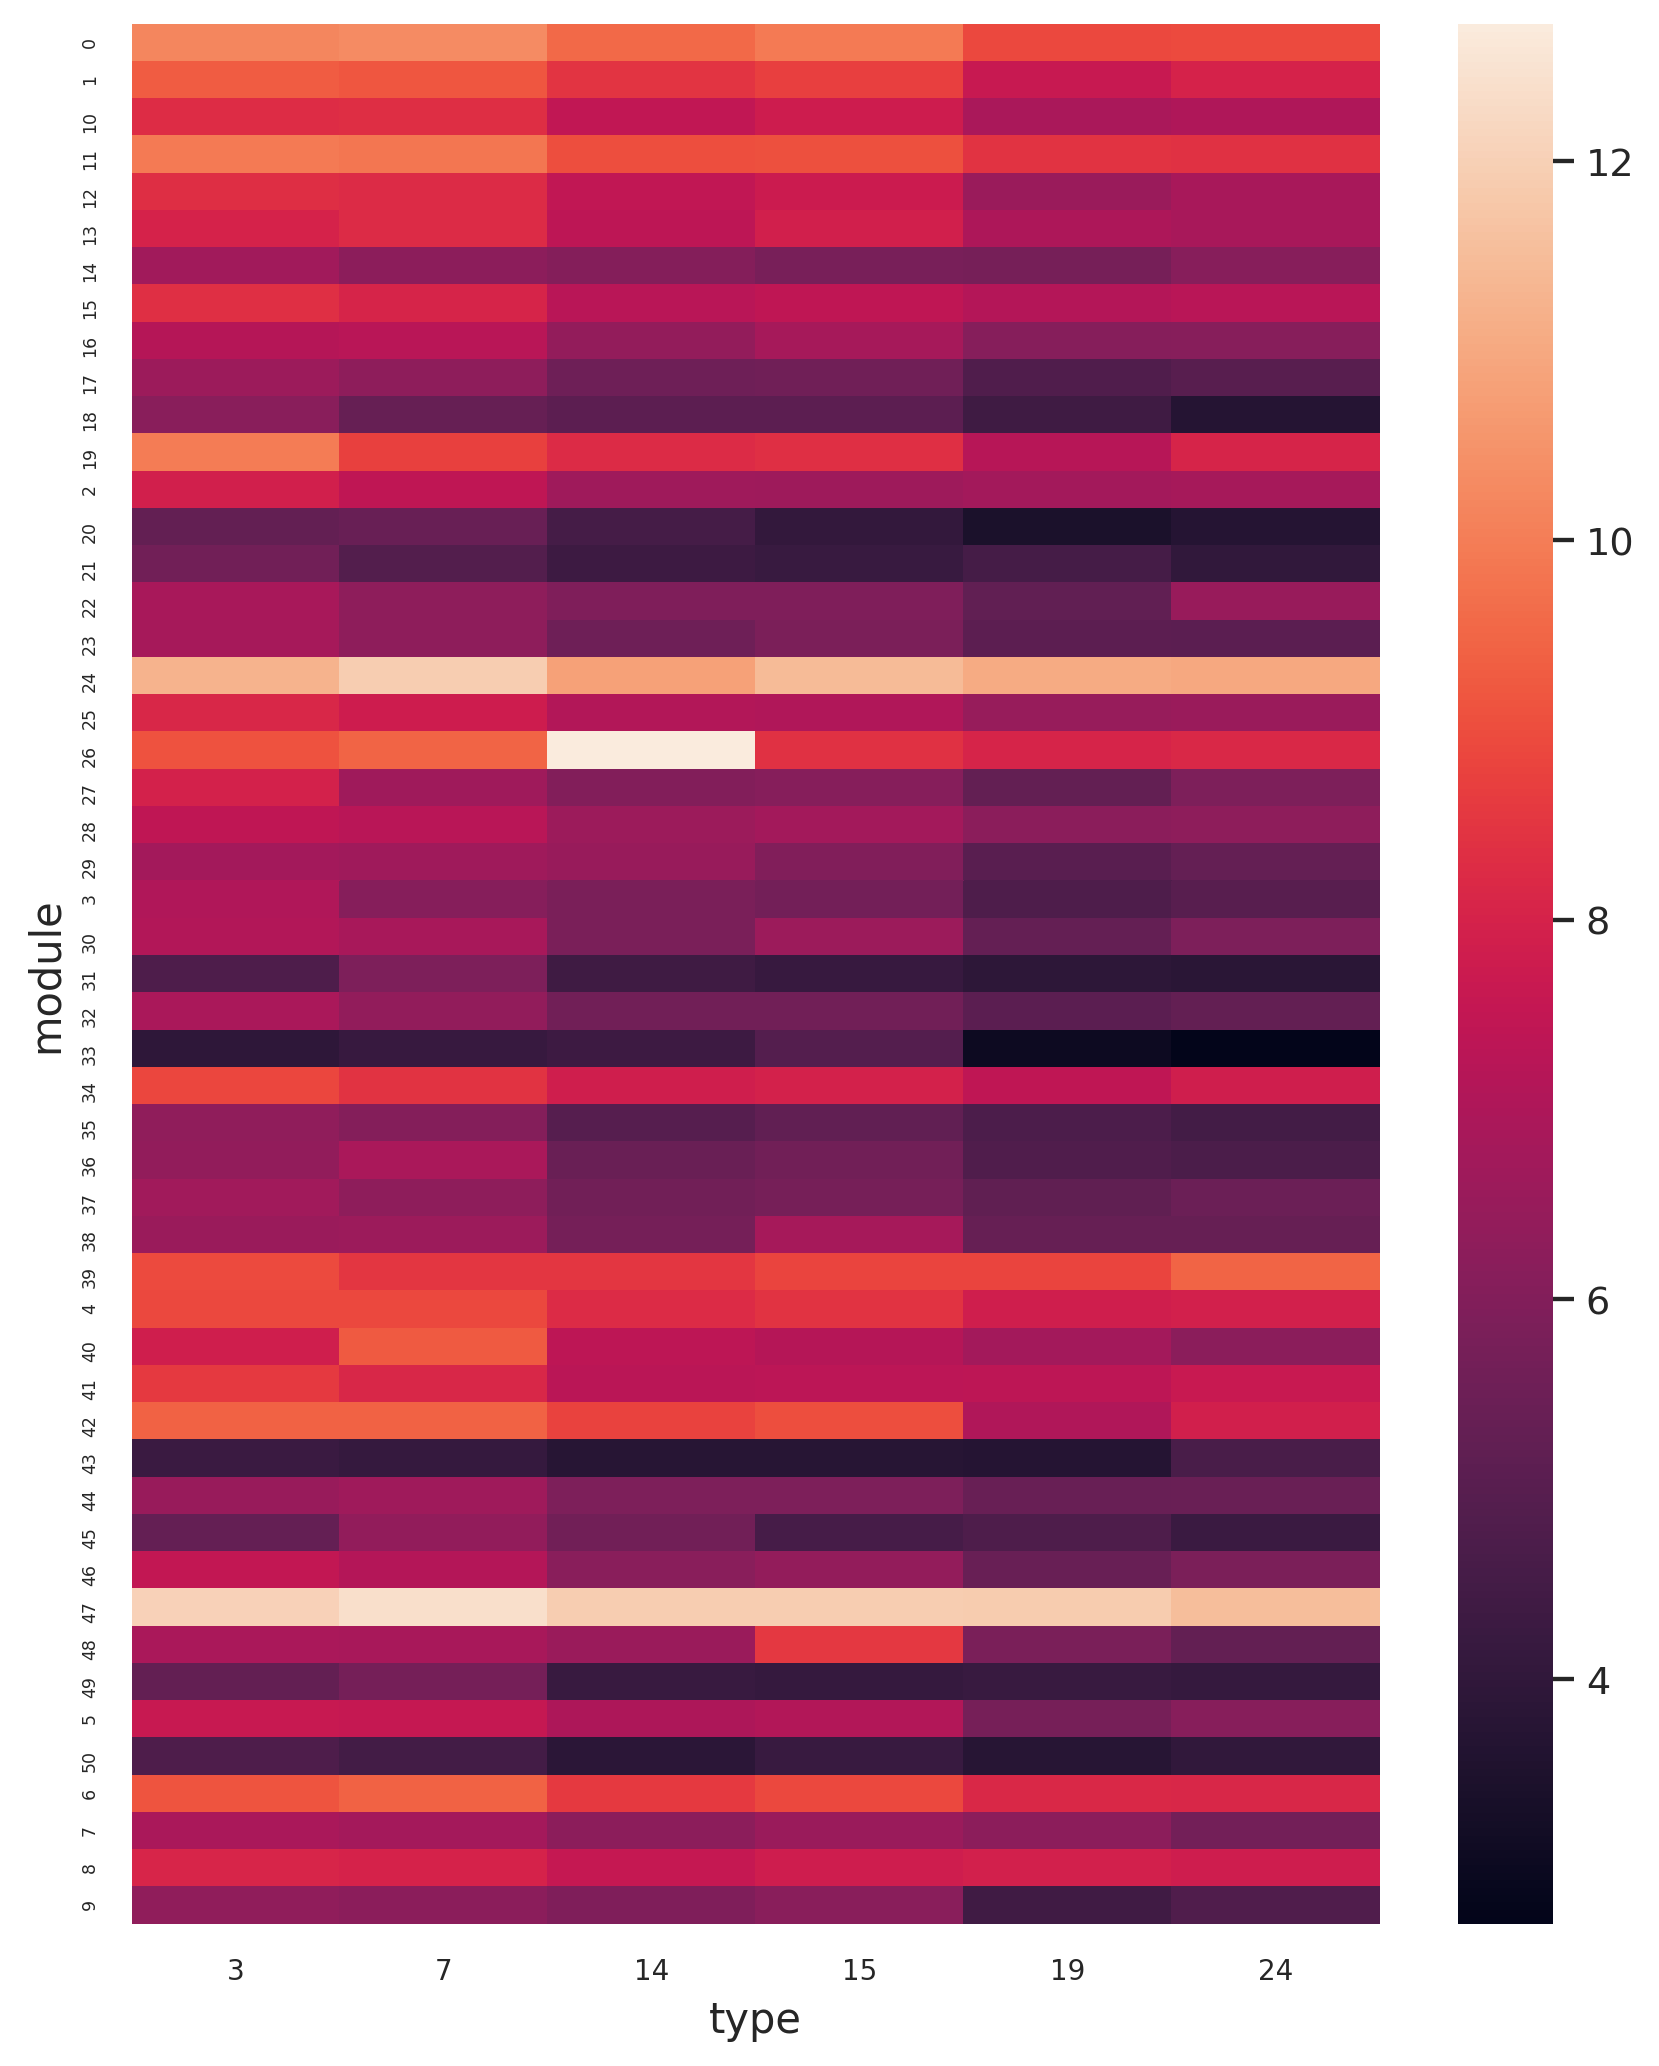

In [ ]:
#Original hvgs, res = 4
plt.figure(figsize=(8,10))
plt.yticks(fontsize=5)
plt.xticks(fontsize=8)
ax = sns.heatmap(modExpr)

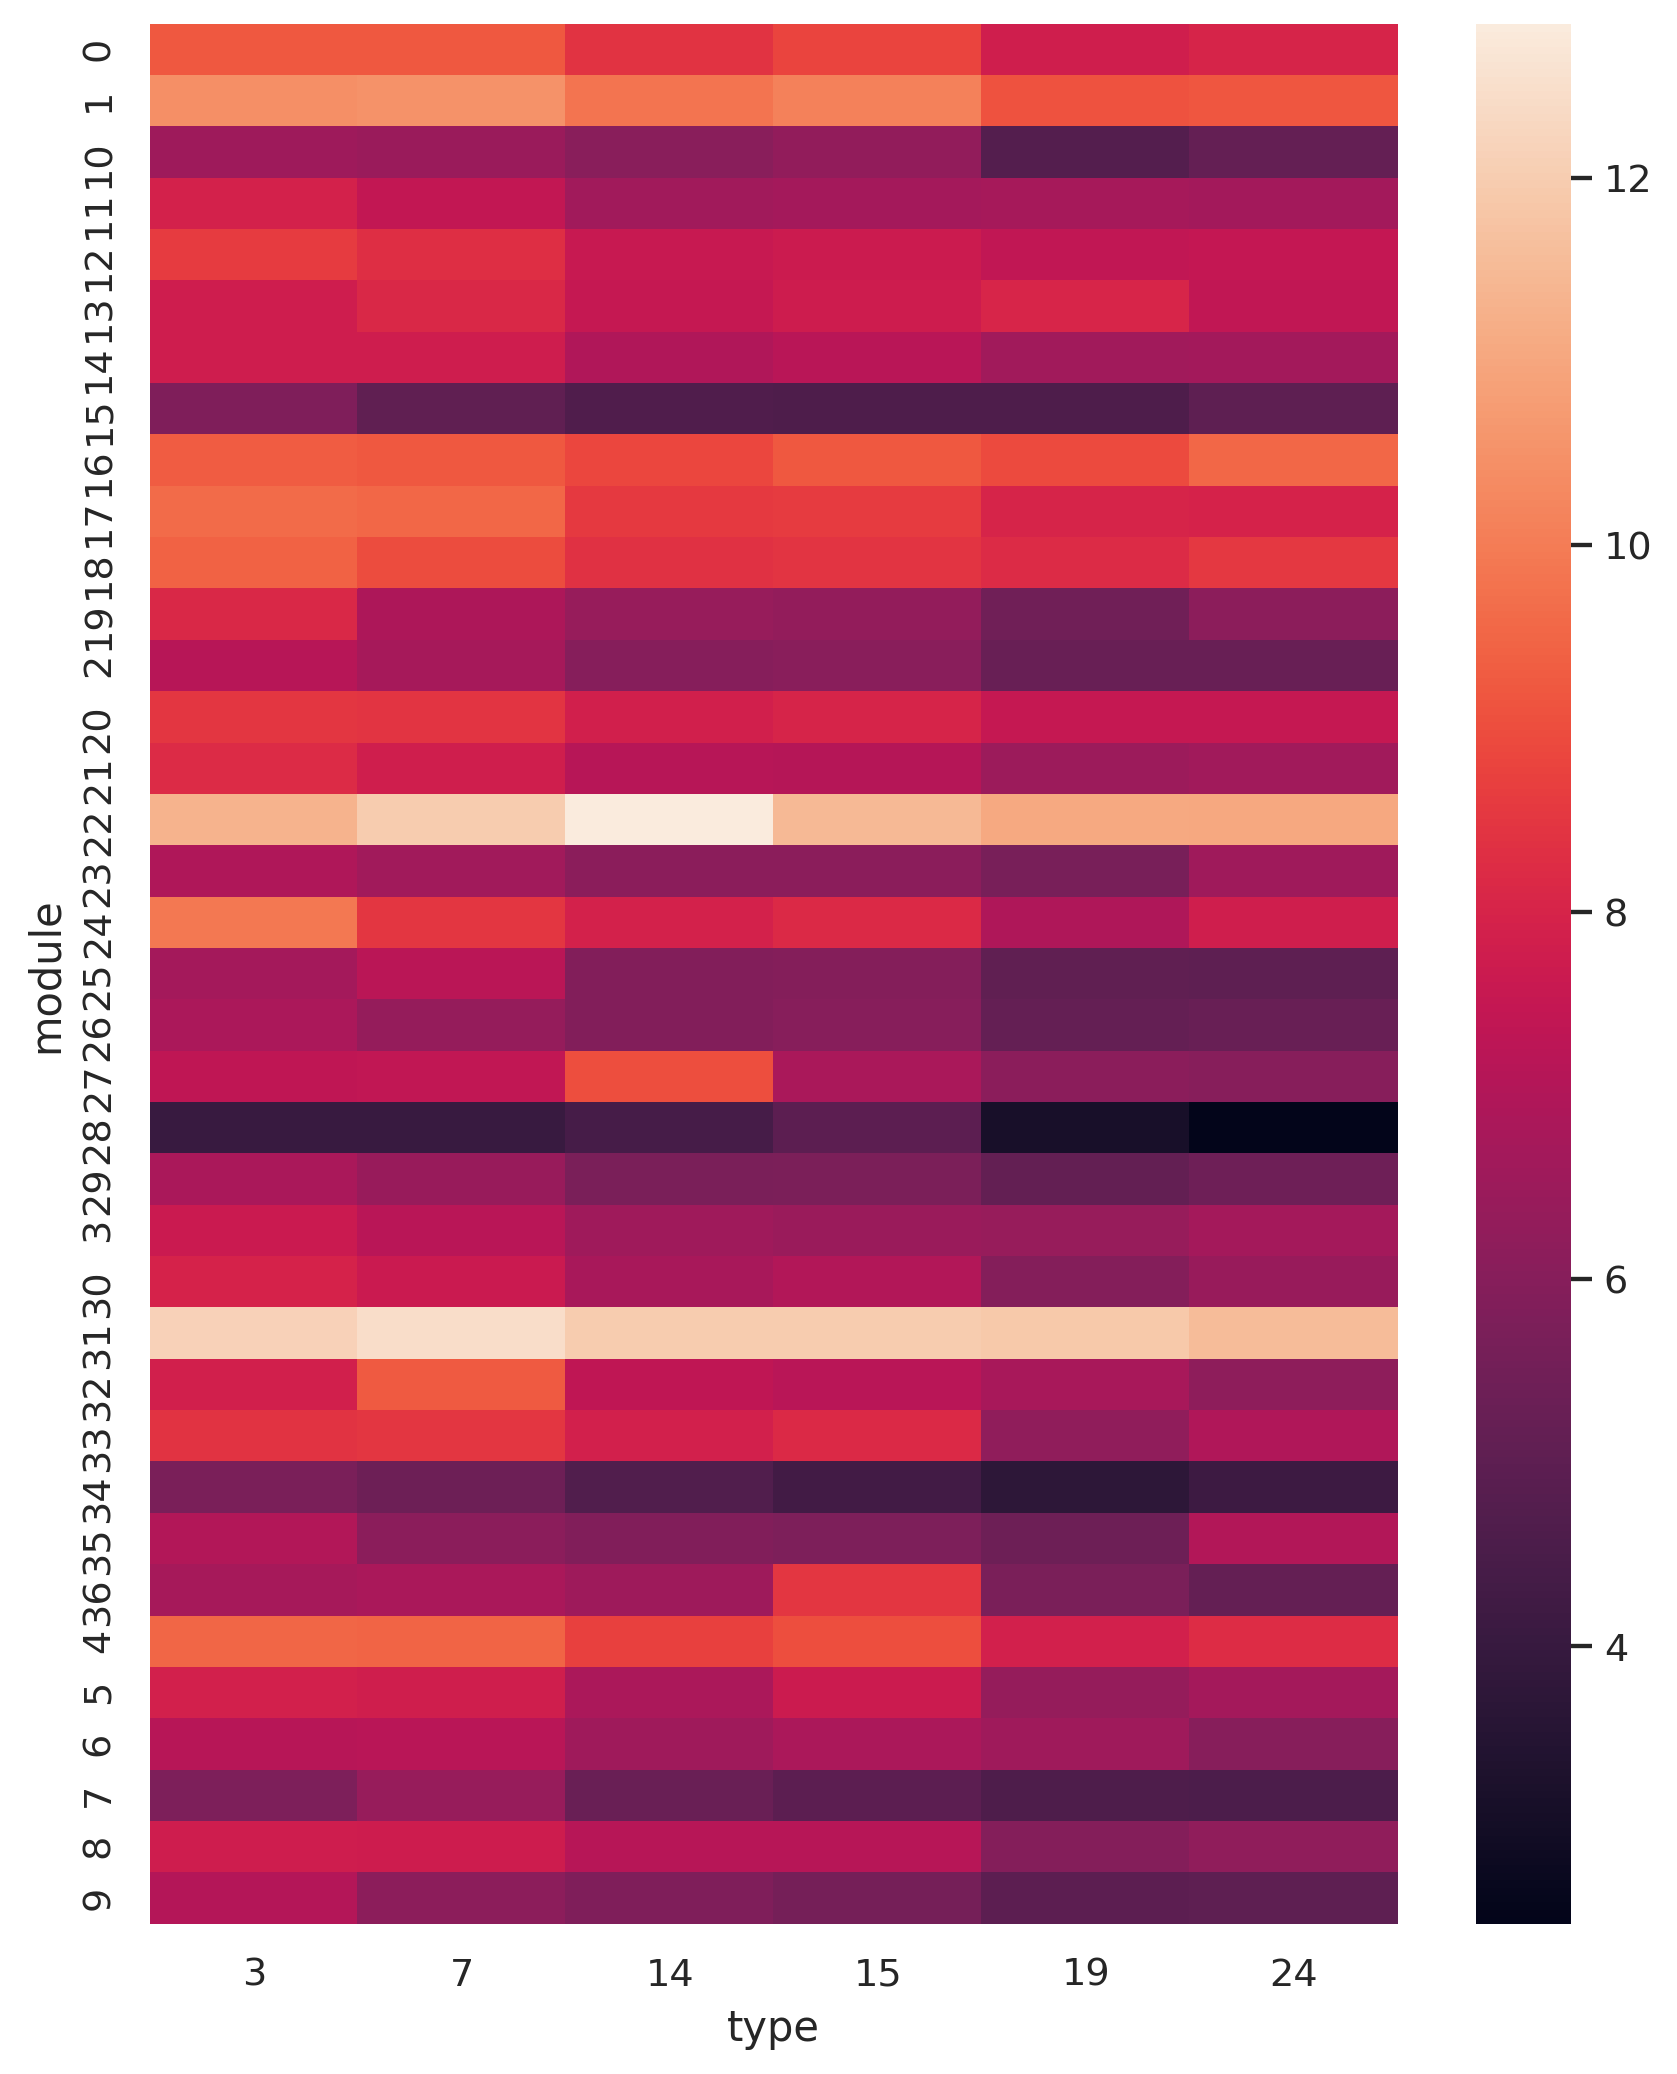

In [ ]:
#Original hvgs
plt.figure(figsize=(8,10))
ax = sns.heatmap(modExpr)

Check for GO Term Enrichment in Modules

In [ ]:
#For topGO analysis (To Assign Labels to Modules)

def returnVal(i):
  if i == i:
    i= i.replace("[","")
    i = i.replace("]","")
    i= i.replace("'","")
    i = i.replace("'","")
    return i 
  else:
    return 'nan'

genesDF.goTerms = [returnVal(str(i)) for i in list(genesDF.goTerms)]
genesDF = genesDF[genesDF.goTerms != 'nan']
genesDF = genesDF[genesDF.Cluster != 'padjClus_not_sig']

genesDF.to_csv('genes_fortopGO_metadata.txt',sep='\t',columns=['Genes','goTerms','Cluster'],
             header=None,index_label=False,index=False)
genesDF.to_csv('genes_fortopGO.txt',sep='\t',columns=['Genes','goTerms'],
             header=None,index_label=False,index=False)

In [ ]:
%%R 

install.packages('rlang')
if (!requireNamespace("BiocManager", quietly=TRUE)){
  install.packages("BiocManager")
}

BiocManager::install("topGO")


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/rlang_0.4.10.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 915685 bytes (894 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

Update all/some/none? [a/s/n]: a


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/dbplyr_2.1.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 581845 bytes (568 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]

In [ ]:
%%R

library(topGO)
library(readr)
#Read in DE genes (XLOC's) with GO Terms
geneID2GO <- readMappings(file = "genes_fortopGO.txt")
str(head(geneID2GO ))

#Add gene modules as factor 
genes_fortopGO_metadata <- read_delim("genes_fortopGO_metadata.txt", 
                                                   "\t", escape_double = FALSE, col_names = FALSE, 
                                                   trim_ws = TRUE)

#Set variables
allMods = unique(genes_fortopGO_metadata$X3)
alpha = 0.05/length(allMods) #Bonferroni correction, could correct for all pairwise comparisons?


getEnrichTerms <- function(geneID2GO, modMetadata, clus){
  mods <- factor(as.integer(modMetadata$X3 == clus)) #Choose gene module to make 'interesting'
  names(mods) <- names(geneID2GO)

  
  #Get genes only in module of interest
  clusGenes <- function(mods) {
    return(mods == 1)
  }
  subMods <- clusGenes(mods)
  
  #Make GO data
  GOdata <- new("topGOdata", ontology = "BP", allGenes = mods,
                geneSel = subMods, annot = annFUN.gene2GO, gene2GO = geneID2GO)
  
  #GOdata
  #sigGenes(GOdata)
  
  resultFis <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
  
  resultWeight <- runTest(GOdata, statistic = "fisher")

  #P-values from Weight Algorithm
  pvalsWeight <- score(resultWeight)
  
  #hist(pvalsWeight, 50, xlab = "p-values")
  
  allRes <- GenTable(GOdata, classic = resultFis, weight = resultWeight, 
                     orderBy = "weight", ranksOf = "classic", topNodes = 20)
  
  subRes <- allRes[as.numeric(allRes$weight) < alpha,]

  subRes$module <- rep(clus, length(subRes$weight))

  print(subRes)
  
  #Write output
  write.csv(subRes,file=paste('mod',clus,'_GOTerms.csv',sep=""))
}

#Run for all modules and write outputs
for(c in allMods){
  
  getEnrichTerms(geneID2GO = geneID2GO,modMetadata = genes_fortopGO_metadata, clus = c)
  
}

List of 6
 $ XLOC_000079: chr [1:10] "GO:0044238" "GO:0006457" "GO:0016853" "GO:0019538" ...
 $ XLOC_000112: chr [1:11] "GO:0019722" "GO:0009987" "GO:0007165" "GO:0006928" ...
 $ XLOC_000296: chr [1:6] "GO:0044238" "GO:0006629" "GO:0003824" "GO:0008152" ...
 $ XLOC_000404: chr [1:12] "GO:0005737" "GO:0043234" "GO:0006810" "GO:0032991" ...
 $ XLOC_000487: chr [1:4] "GO:0016787" "GO:0006796" "GO:0008152" "GO:0003824"
 $ XLOC_000618: chr [1:4] "GO:0005634" "GO:0044464" "GO:0043226" "GO:0005622"

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_character(),
  X3 = col_double()
)



R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 391 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 391 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	7 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	11 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	13 nodes to be scored	(395 eliminated genes)

R[write to console]: 
	 Level 9:	30 nodes to be scored	(46

       GO.ID                                 Term Annotated Significant
1 GO:0022904 respiratory electron transport chain        34           8
  Expected Rank in classic classic weight module
1     1.88               2 0.00040 0.0004      0


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 292 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 292 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	7 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(385 eliminated genes)

R[write to console]: 
	 Level 9:	15 nodes to be scored	(452 eliminated genes)

R[write to console]: 
	 Level 8:	31 nodes to be scored	(60

       GO.ID                         Term Annotated Significant Expected
1 GO:0006351 transcription, DNA-templated       368          32    15.69
  Rank in classic classic  weight module
1              22 4.6e-05 0.00021      1


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 284 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 284 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(382 eliminated genes)

R[write to console]: 
	 Level 9:	13 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 8:	25 nodes to be scored	(59

       GO.ID                                        Term Annotated Significant
1 GO:0006796 phosphate-containing compound metabolic ...       596          36
  Expected Rank in classic classic  weight module
1     20.4               2 0.00024 1.9e-05     10


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 284 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 284 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	12 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	20 nodes to be scored	(57

       GO.ID                          Term Annotated Significant Expected
1 GO:0051180             vitamin transport        54          10     1.07
2 GO:0009605 response to external stimulus       118          13     2.33
3 GO:0007398          ectoderm development        88          10     1.74
4 GO:0006508                   proteolysis       244          16     4.81
5 GO:0007601             visual perception        62           8     1.22
6 GO:0006897                   endocytosis       170          13     3.35
7 GO:0007498          mesoderm development        99           9     1.95
  Rank in classic classic  weight module
1               1 5.5e-08 5.5e-08     11
2               2 2.9e-07 1.3e-06     11
3               3 6.1e-06 6.1e-06     11
4               4 1.3e-05 1.3e-05     11
5               6 2.2e-05 2.2e-05     11
6               5 1.9e-05 2.3e-05     11
7               9 0.00011 0.00011     11


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 343 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 343 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	8 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(374 eliminated genes)

R[write to console]: 
	 Level 9:	16 nodes to be scored	(452 eliminated genes)

R[write to console]: 
	 Level 8:	33 nodes to be scored	(60

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 336 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 336 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	9 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	17 nodes to be scored	(444 eliminated genes)

R[write to console]: 
	 Level 8:	28 nodes to be scored	(60

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 296 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 296 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	12 nodes to be scored	(395 eliminated genes)

R[write to console]: 
	 Level 8:	28 nodes to be scored	(54

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 266 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 266 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(371 eliminated genes)

R[write to console]: 
	 Level 9:	14 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	23 nodes to be scored	(55

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 330 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 330 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	10 nodes to be scored	(376 eliminated genes)

R[write to console]: 
	 Level 9:	17 nodes to be scored	(446

       GO.ID                                Term Annotated Significant Expected
1 GO:0007249 I-kappaB kinase/NF-kappaB signaling        69           9     2.06
2 GO:0007254                         JNK cascade        58           8     1.73
  Rank in classic classic  weight module
1               1 0.00017 0.00017     16
2               2 0.00027 0.00027     16


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 234 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 234 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	9 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	18 nodes to be scored	(529

       GO.ID                                 Term Annotated Significant
1 GO:0007502 digestive tract mesoderm development         2           2
2 GO:0009790                   embryo development        24           4
3 GO:0007379                segment specification        11           3
  Expected Rank in classic classic  weight module
1     0.03               1 0.00027 0.00027     17
2     0.40               4 0.00056 0.00056     17
3     0.18               5 0.00064 0.00064     17


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 253 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 253 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	10 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	20 nodes to be scored	(49

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 263 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 263 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	6 nodes to be scored	(395 eliminated genes)

R[write to console]: 
	 Level 8:	18 nodes to be scored	(497

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 310 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 310 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(376 eliminated genes)

R[write to console]: 
	 Level 9:	19 nodes to be scored	(434 

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 245 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 245 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	8 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	18 nodes to be scored	(451

       GO.ID                             Term Annotated Significant Expected
1 GO:0006812                 cation transport       162          14     2.63
2 GO:0050789 regulation of biological process      1187          30    19.28
  Rank in classic classic  weight module
1               1 1.5e-07 1.5e-07     20
2               3  0.0023 4.3e-06     20


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 221 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 221 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	8 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	16 nodes to be scored	(529

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 263 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 263 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(334 eliminated genes)

R[write to console]: 
	 Level 9:	8 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	22 nodes to be scored	(553

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 249 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 249 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	22 nodes to be scored	(56

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 223 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 223 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	7 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	17 nodes to be scored	(482

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 183 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 183 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	6 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	12 nodes to be scored	(380

       GO.ID                 Term Annotated Significant Expected
1 GO:0007160 cell-matrix adhesion        51           5     0.68
  Rank in classic classic weight module
1               1  0.0005 0.0005     25


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 241 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 241 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	6 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	15 nodes to be scored	(484

       GO.ID                   Term Annotated Significant Expected
1 GO:0006811          ion transport       214           9     4.22
2 GO:0008643 carbohydrate transport        12           4     0.24
  Rank in classic classic  weight module
1               4  0.0232 1.9e-06     26
2               1 6.1e-05 6.1e-05     26


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 254 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 254 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	10 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	18 nodes to be scored	(54

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 295 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 295 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	7 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	9 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 9:	17 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 8:	28 nodes to be scored	(60

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 266 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 266 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(373 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 8:	21 nodes to be scored	(54

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 306 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 306 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(386 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	27 nodes to be scored	(56

       GO.ID                                Term Annotated Significant Expected
1 GO:0007274 neuromuscular synaptic transmission         2           2     0.06
  Rank in classic classic  weight module
1               7 0.00095 0.00095      3


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 213 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 213 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	7 nodes to be scored	(382 eliminated genes)

R[write to console]: 
	 Level 8:	13 nodes to be scored	(463

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 249 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 249 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	8 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	19 nodes to be scored	(516

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 278 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 278 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	24 nodes to be scored	(56

       GO.ID                   Term Annotated Significant Expected
1 GO:0007059 chromosome segregation        60           6     1.15
  Rank in classic classic  weight module
1               1 0.00087 0.00087     32


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 180 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 180 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	8 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	10 nodes to be scored	(516

       GO.ID                   Term Annotated Significant Expected
1 GO:0050877 nervous system process       184           7     2.03
  Rank in classic classic  weight module
1               2  0.0034 0.00097     33


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 212 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 212 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	12 nodes to be scored	(329 eliminated genes)

R[write to console]: 
	 Level 8:	16 nodes to be scored	(56

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 222 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 222 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	8 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	14 nodes to be scored	(533

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 257 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 257 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	14 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	22 nodes to be scored	(61

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 218 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 218 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	7 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	16 nodes to be scored	(412

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 217 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 217 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(334 eliminated genes)

R[write to console]: 
	 Level 9:	7 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	15 nodes to be scored	(521

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 206 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 206 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(374 eliminated genes)

R[write to console]: 
	 Level 8:	16 nodes to be scored	(42

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 304 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 304 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(374 eliminated genes)

R[write to console]: 
	 Level 9:	14 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 8:	24 nodes to be scored	(62

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 190 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 190 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(276 eliminated genes)

R[write to console]: 
	 Level 9:	5 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	13 nodes to be scored	(516

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 147 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 147 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(265 eliminated genes)

R[write to console]: 
	 Level 9:	5 nodes to be scored	(337 eliminated genes)

R[write to console]: 
	 Level 8:	8 nodes to be scored	(381 

       GO.ID                       Term Annotated Significant Expected
1 GO:0006260            DNA replication        67           5     0.52
2 GO:0007005 mitochondrion organization        18           3     0.14
3 GO:0006259      DNA metabolic process       157           7     1.23
  Rank in classic classic  weight module
1               1 0.00014 0.00014     41
2               3 0.00032 0.00032     41
3               2 0.00015 0.00047     41


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 176 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 176 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(58 eliminated genes)

R[write to console]: 
	 Level 9:	5 nodes to be scored	(58 eliminated genes)

R[write to console]: 
	 Level 8:	12 nodes to be scored	(450 e

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 159 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 159 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	4 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	8 nodes to be scored	(484 

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 245 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 245 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(340 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(401 

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 207 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 207 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	6 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	16 nodes to be scored	(413

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 172 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 172 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(334 eliminated genes)

R[write to console]: 
	 Level 9:	5 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	9 nodes to be scored	(484 

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 163 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 163 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	2 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	4 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	10 nodes to be scored	(368

       GO.ID                 Term Annotated Significant Expected
1 GO:0006508          proteolysis       244           9     1.77
2 GO:0007398 ectoderm development        88           5     0.64
3 GO:0051180    vitamin transport        54           4     0.39
4 GO:0007498 mesoderm development        99           5     0.72
5 GO:0007601    visual perception        62           4     0.45
  Rank in classic classic  weight module
1               1 2.9e-05 2.9e-05     47
2               2 0.00034 0.00034     47
3               3 0.00053 0.00053     47
4               4 0.00059 0.00059     47
5               5 0.00090 0.00090     47


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 115 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 115 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	3 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	5 nodes to be scored	(484 

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 93 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 93 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 9:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 8:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 7:	5 nodes to be scored	(365 eliminated genes)

R[write to console]: 
	 Level 6:	11 nodes to be scored	(760 eliminated genes)

R[write to console]: 
	 Level 5:	17 nodes to be scored	(1086 el

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 319 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 319 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(376 eliminated genes)

R[write to console]: 
	 Level 9:	16 nodes to be scored	(434 

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 124 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 124 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	2 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	4 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	8 nodes to be scored	(368 

       GO.ID                              Term Annotated Significant Expected
1 GO:0006790 sulfur compound metabolic process        46           3     0.19
  Rank in classic classic  weight module
1               1 0.00073 0.00073     50


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 296 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 296 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(373 eliminated genes)

R[write to console]: 
	 Level 9:	10 nodes to be scored	(452 eliminated genes)

R[write to console]: 
	 Level 8:	27 nodes to be scored	(62

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 306 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 306 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(335 eliminated genes)

R[write to console]: 
	 Level 9:	14 nodes to be scored	(389 

[1] GO.ID           Term            Annotated       Significant    
[5] Expected        Rank in classic classic         weight         
[9] module         
<0 rows> (or 0-length row.names)


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 245 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 245 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	10 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	18 nodes to be scored	(56

       GO.ID                              Term Annotated Significant Expected
1 GO:0035556 intracellular signal transduction       322          23    10.09
  Rank in classic classic  weight module
1               1 0.00011 0.00096      8


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 254 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 254 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	15 nodes to be scored	(382 eliminated genes)

R[write to console]: 
	 Level 8:	25 nodes to be scored	(62

       GO.ID                                    Term Annotated Significant
1 GO:0007166 cell surface receptor signaling pathway       389          21
2 GO:0007160                    cell-matrix adhesion        51           7
  Expected Rank in classic classic  weight module
1    10.04               3 0.00065 0.00012      9
2     1.32               1 0.00028 0.00028      9


In [ ]:
import os
import glob


df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "mod*.csv"))))
df.head()

,Unnamed: 0,GO.ID,Term,Annotated,Significant,Expected,Rank in classic,classic,weight,module
0,1,GO:0006811,ion transport,214,9,4.22,4,2.320000e-02,1.900000e-06,26
1,2,GO:0008643,carbohydrate transport,12,4,0.24,1,6.100000e-05,6.100000e-05,26
0,1,GO:0051180,vitamin transport,54,10,1.07,1,5.500000e-08,5.500000e-08,11
1,2,GO:0009605,response to external stimulus,118,13,2.33,2,2.900000e-07,1.300000e-06,11
2,3,GO:0007398,ectoderm development,88,10,1.74,3,6.100000e-06,6.100000e-06,11


In [ ]:
df.to_csv('gastroModulesGOEnrich.csv',index=None)

### **Gland Cell Type Gene Modules**

In [64]:
#Gastroderm: 

gastro = bus_fs_raw[bus_fs_raw.obs['cellRanger_louvain'].isin([22,27,25,32,34])]
gastro_copy = gastro.copy()

#Normalize and scale data
sc.pp.filter_genes(gastro_copy, min_counts=0)
sc.pp.filter_cells(gastro_copy, min_counts=0)

sc.pp.normalize_per_cell(gastro_copy, counts_per_cell_after=1e4)
gastro_copy.raw = sc.pp.log1p(gastro_copy, copy=True)

sc.pp.scale(gastro_copy, max_value=10)

sc.pp.highly_variable_genes(gastro_copy,n_top_genes=15000)
gastro_copy = gastro_copy[:,gastro_copy.var['highly_variable']]
gastro_copy



View of AnnData object with n_obs × n_vars = 634 × 45592
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub', 'n_counts'
    var: 'n_counts', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annos_colors', 'cellRanger_louvain_colors', 'hvg'

In [65]:
#gastro = gastro[:,gastro_copy.var_names]

In [66]:
gastro = gastro[:,bus_fs_combo.var_names]

In [67]:
gastro

View of AnnData object with n_obs × n_vars = 634 × 8696
    obs: 'batch', 'cellRanger_louvain', 'fed', 'orgID', 'annos', 'annosSub'
    uns: 'annos_colors', 'cellRanger_louvain_colors'

In [68]:
#Transpose cellxgene
g_mod = anndata.AnnData(X=gastro.X.T)
g_mod.var_names = gastro.obs_names
g_mod.obs_names = gastro.var_names

print(g_mod)

g_copy = g_mod.copy()

AnnData object with n_obs × n_vars = 8696 × 634


In [69]:
#Scale and cluster genes

#Normalize and scale data
sc.pp.filter_genes(g_copy, min_counts=0)

#sc.pp.normalize_per_cell(g_copy, counts_per_cell_after=1e4)
sc.pp.log1p(g_copy)

sc.pp.scale(g_copy, max_value=10)
sc.tl.pca(g_copy, n_comps=60,random_state=42)
#sc.pl.pca_variance_ratio(bus_combo, log=True)

#Determine neighbors for clustering
sc.pp.neighbors(g_copy,n_neighbors=15, n_pcs=15) #n_neighbors=5, n_pcs=15,  20, n_pcs=15
sc.tl.louvain(g_copy, resolution=4)



In [70]:
# sc.tl.tsne(g_copy, n_pcs=15,random_state=42)
# sc.pl.tsne(g_copy,color=['louvain'])


In [71]:
clusters = np.unique(g_copy.obs['louvain'])

In [72]:
#Louvain clustering on genes across cells

genes = []
cluster = []
for c in clusters:
  sub = g_copy[g_copy.obs['louvain'] == c]
  genes += list(sub.obs_names)
  cluster += [c]*len(sub.obs_names)

genesDF = pd.DataFrame()
genesDF["Genes"] = genes
genesDF["Cluster"] = cluster

genesDF = annotateResDF(genesDF)
genesDF.head()

,Genes,Cluster,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms
0,XLOC_000090,0,NA,NA,[PTHR46360],[DISKS LARGE HOMOLOG 5],[nan]
1,XLOC_000177,0,NA,NA,[PTHR45695],[LEUCOKININ RECEPTOR-RELATED],"[GO:0004930,GO:0016020,GO:0016021,GO:0007166,G..."
2,XLOC_000142,0,TUBGCP5,gamma-tubulin complex component 5 isoform a [...,[PTHR19302:SF33],[GAMMA-TUBULIN COMPLEX COMPONENT 5],"[GO:0005200,GO:0070271,GO:0005488,GO:0007067,G..."
3,XLOC_000065,0,NA,NA,[PTHR10166],[VOLTAGE-DEPENDENT CALCIUM CHANNEL SUBUNIT ALP...,[nan]
4,XLOC_000141,0,IVD,"PREDICTED: isovaleryl-CoA dehydrogenase, mito...",[PTHR43884:SF12],"[ISOVALERYL-COA DEHYDROGENASE, MITOCHONDRIAL-R...","[GO:0005737,GO:0044238,GO:0006631,GO:0006629,G..."


In [73]:
genesDF.to_csv('glandModules.csv',index=None)

In [74]:
#Plot heatmap of average expression for each gene module in each cell type
modExpr = pd.DataFrame()
module = []
c_type = []
expr = []

cell_types = np.unique(gastro.obs['cellRanger_louvain'])
for i in clusters:
  #Get list of genes
  sub = g_copy[g_copy.obs['louvain'] == i]
  genes = list(sub.obs_names)

  for j in cell_types:
  #Filter cells and genes
    sub_g = gastro[gastro.obs['cellRanger_louvain'] == j]
    sub_g = sub_g[:,genes]
    expr += [np.log1p(np.sum(sub_g.X))]

    c_type += [j]
    module += [i]

modExpr['module'] = module
modExpr['type'] = c_type
modExpr['expr'] = expr


modExpr.head()
modExpr = modExpr.pivot("module", "type", "expr")

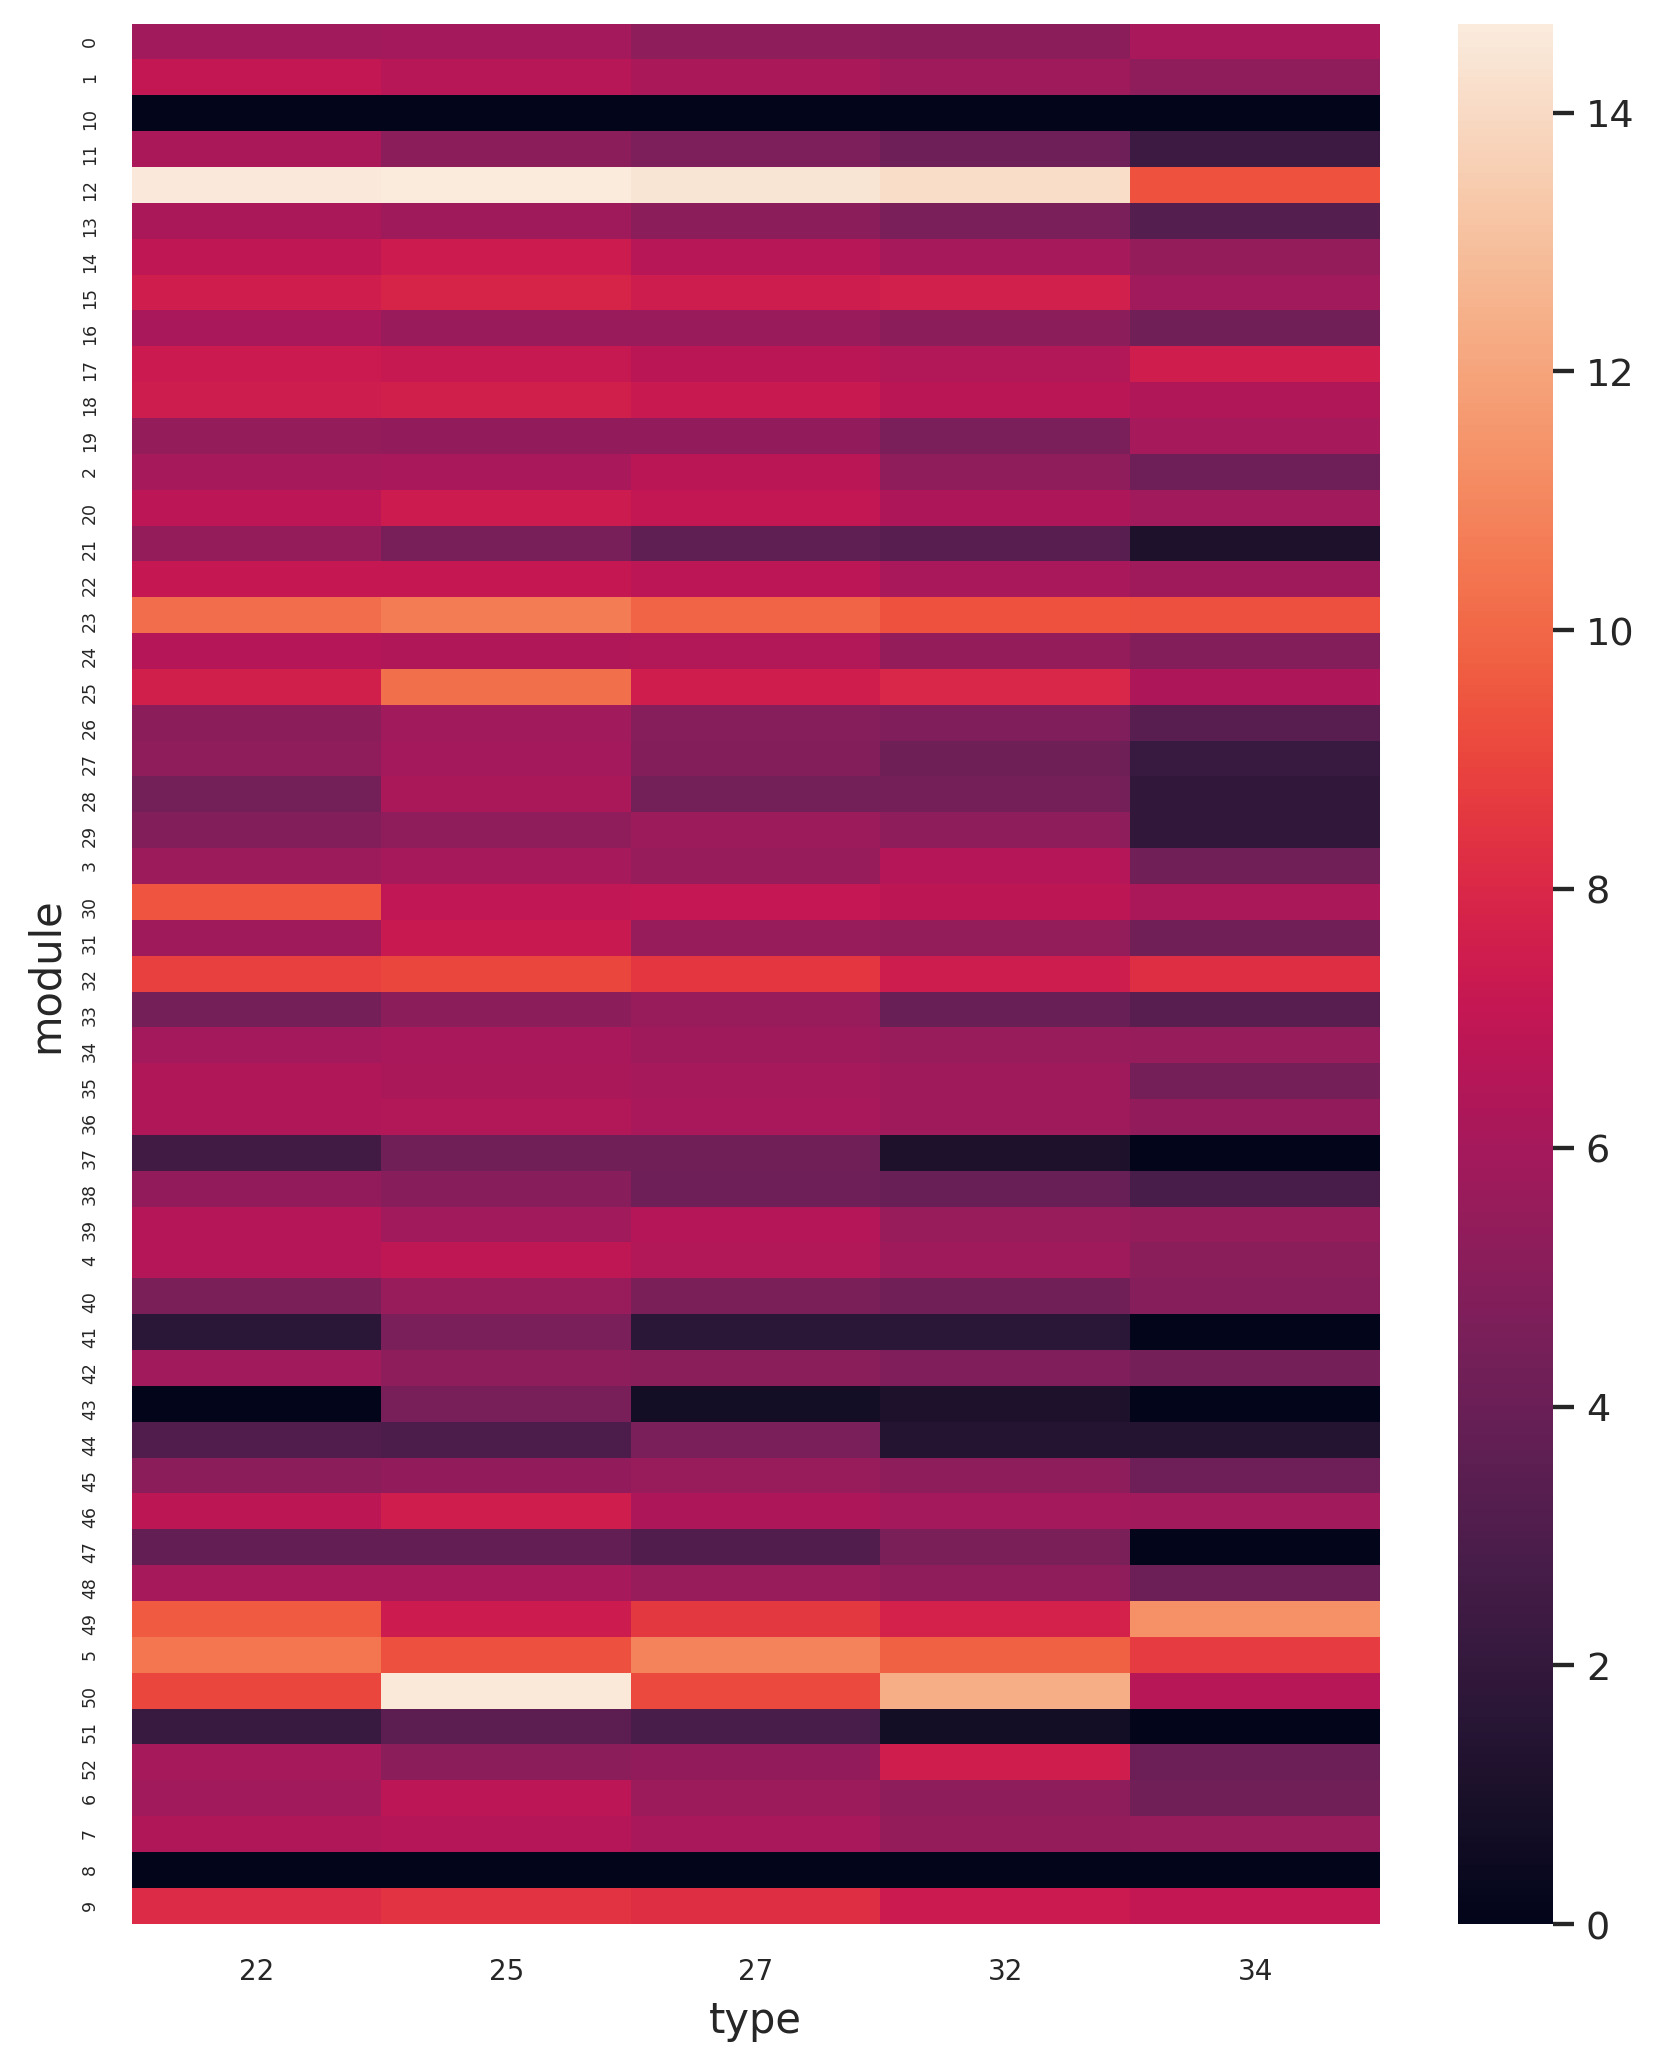

In [75]:
#Original hvgs, res = 4
plt.figure(figsize=(8,10))
plt.yticks(fontsize=5)
plt.xticks(fontsize=8)
ax = sns.heatmap(modExpr)

Check for GO Term Enrichment in Modules

In [76]:
#For topGO analysis (To Assign Labels to Modules)

def returnVal(i):
  if i == i:
    i= i.replace("[","")
    i = i.replace("]","")
    i= i.replace("'","")
    i = i.replace("'","")
    return i 
  else:
    return 'nan'

genesDF.goTerms = [returnVal(str(i)) for i in list(genesDF.goTerms)]
genesDF = genesDF[genesDF.goTerms != 'nan']
genesDF = genesDF[genesDF.Cluster != 'padjClus_not_sig']

genesDF.to_csv('genes_fortopGO_metadata.txt',sep='\t',columns=['Genes','goTerms','Cluster'],
             header=None,index_label=False,index=False)
genesDF.to_csv('genes_fortopGO.txt',sep='\t',columns=['Genes','goTerms'],
             header=None,index_label=False,index=False)

In [77]:
%%R 

install.packages('rlang')
if (!requireNamespace("BiocManager", quietly=TRUE)){
  install.packages("BiocManager")
}

BiocManager::install("topGO")


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/rlang_0.4.10.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 915685 bytes (894 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write

Update all/some/none? [a/s/n]: a


R[write to console]: also installing the dependencies ‘data.table’, ‘gargle’, ‘ids’, ‘dtplyr’, ‘googledrive’, ‘googlesheets4’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/data.table_1.14.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 5303849 bytes (5.1 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


In [82]:
%%R

library(topGO)
library(readr)
#Read in DE genes (XLOC's) with GO Terms
geneID2GO <- readMappings(file = "genes_fortopGO.txt")
str(head(geneID2GO ))

#Add gene modules as factor 
genes_fortopGO_metadata <- read_delim("genes_fortopGO_metadata.txt", 
                                                   "\t", escape_double = FALSE, col_names = FALSE, 
                                                   trim_ws = TRUE)

#Set variables
allMods = unique(genes_fortopGO_metadata$X3)
alpha = 0.05#/length(allMods) #Bonferroni correction, could correct for all pairwise comparisons?


getEnrichTerms <- function(geneID2GO, modMetadata, clus){
  mods <- factor(as.integer(modMetadata$X3 == clus)) #Choose gene module to make 'interesting'
  names(mods) <- names(geneID2GO)

  
  #Get genes only in module of interest
  clusGenes <- function(mods) {
    return(mods == 1)
  }
  subMods <- clusGenes(mods)
  
  #Make GO data
  GOdata <- new("topGOdata", ontology = "BP", allGenes = mods,
                geneSel = subMods, annot = annFUN.gene2GO, gene2GO = geneID2GO)
  
  #GOdata
  #sigGenes(GOdata)
  
  resultFis <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
  
  resultWeight <- runTest(GOdata, statistic = "fisher")

  #P-values from Weight Algorithm
  pvalsWeight <- score(resultWeight)
  
  #hist(pvalsWeight, 50, xlab = "p-values")
  
  allRes <- GenTable(GOdata, classic = resultFis, weight = resultWeight, 
                     orderBy = "weight", ranksOf = "classic", topNodes = 20)
  
  subRes <- allRes[as.numeric(allRes$weight) < alpha,]

  subRes$module <- rep(clus, length(subRes$weight))

  print(subRes)
  
  #Write output
  write.csv(subRes,file=paste('mod',clus,'_GOTerms.csv',sep=""))
}

#Run for all modules and write outputs
for(c in allMods){
  
  getEnrichTerms(geneID2GO = geneID2GO,modMetadata = genes_fortopGO_metadata, clus = c)
  
}

List of 6
 $ XLOC_000177                  : chr [1:19] "GO:0004930" "GO:0016020" "GO:0016021" "GO:0007166" ...
 $ XLOC_000142                  : chr [1:26] "GO:0005200" "GO:0070271" "GO:0005488" "GO:0007067" ...
 $ XLOC_000141                  : chr [1:18] "GO:0005737" "GO:0044238" "GO:0006631" "GO:0006629" ...
 $ XLOC_000463                  : chr [1:25] "GO:0006807" "GO:0043226" "GO:0005737" "GO:0006139" ...
 $ TRINITY_DN2688_c0_g1_i2.mrna2: chr NA
 $ XLOC_000515                  : chr [1:11] "GO:0006996" "GO:0032502" "GO:0005622" "GO:0007010" ...

── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_character(),
  X3 = col_double()
)



R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 325 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 325 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(373 eliminated genes)

R[write to console]: 
	 Level 9:	16 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	30 nodes to be scored	(59

       GO.ID                                     Term Annotated Significant
1 GO:0006635                fatty acid beta-oxidation        12           3
2 GO:0007259  receptor signaling pathway via JAK-STAT        15           3
3 GO:0035556        intracellular signal transduction       322          20
4 GO:0007049                               cell cycle       335          21
5 GO:0006351             transcription, DNA-templated       368          21
6 GO:0007610                                 behavior         1           1
7 GO:0050909              sensory perception of taste         1           1
8 GO:0043066 negative regulation of apoptotic process        19           3
  Expected Rank in classic classic weight module
1     0.53               4   0.014  0.014      0
2     0.66              13   0.026  0.026      0
3    14.20              35   0.070  0.027      0
4    14.77              32   0.059  0.029      0
5    16.23              46   0.127  0.037      0
6     0.04            

R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 323 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 323 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(386 eliminated genes)

R[write to console]: 
	 Level 9:	12 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	29 nodes to be scored	(59

       GO.ID                                        Term Annotated Significant
1 GO:0006468                     protein phosphorylation       287          22
2 GO:0051169                           nuclear transport        24           4
3 GO:0035556           intracellular signal transduction       322          19
4 GO:0006521 regulation of cellular amino acid metabo...         6           2
  Expected Rank in classic classic  weight module
1    13.65               4   0.016 0.00016      1
2     1.14               8   0.025 0.02491      1
3    15.32              42   0.189 0.02528      1
4     0.29               9   0.030 0.02974      1


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 254 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 254 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	5 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	15 nodes to be scored	(521

       GO.ID                                        Term Annotated Significant
1 GO:0009566                               fertilization        35           4
2 GO:0002504 antigen processing and presentation of p...         6           2
3 GO:0007155                               cell adhesion       163           9
4 GO:0019221         cytokine-mediated signaling pathway        61           4
  Expected Rank in classic classic weight module
1     0.75               1  0.0062 0.0062     10
2     0.13               2  0.0065 0.0065     10
3     3.50               3  0.0074 0.0088     10
4     1.31              13  0.0407 0.0407     10


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 293 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 293 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(376 eliminated genes)

R[write to console]: 
	 Level 9:	16 nodes to be scored	(434 

       GO.ID                                Term Annotated Significant Expected
1 GO:0000165                        MAPK cascade       117           6     2.95
2 GO:0007270 neuron-neuron synaptic transmission        14           2     0.35
  Rank in classic classic weight module
1               9   0.073  0.016     11
2               2   0.047  0.047     11


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 257 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 257 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	8 nodes to be scored	(337 eliminated genes)

R[write to console]: 
	 Level 8:	18 nodes to be scored	(418

        GO.ID                            Term Annotated Significant Expected
1  GO:0051180               vitamin transport        54          14     1.41
2  GO:0006508                     proteolysis       244          25     6.37
3  GO:0009605   response to external stimulus       118          18     3.08
4  GO:0007398            ectoderm development        88          14     2.30
5  GO:0007601               visual perception        62          12     1.62
6  GO:0006897                     endocytosis       170          19     4.44
7  GO:0007268  chemical synaptic transmission       119          14     3.11
8  GO:0007498            mesoderm development        99          12     2.58
9  GO:0006497              protein lipidation        21           4     0.55
10 GO:0006886 intracellular protein transport       365          19     9.53
11 GO:0006898   receptor-mediated endocytosis        65           5     1.70
12 GO:0006858         extracellular transport        10           2     0.26

R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 320 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 320 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	15 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	29 nodes to be scored	(57

       GO.ID                                        Term Annotated Significant
1 GO:0019724                    B cell mediated immunity         7           2
2 GO:0007292                    female gamete generation        24           3
3 GO:0006629                     lipid metabolic process       225          12
4 GO:0030101              natural killer cell activation         1           1
5 GO:0006869                             lipid transport        47           4
6 GO:0007169 transmembrane receptor protein tyrosine ...        48           4
7 GO:0042116                       macrophage activation        11           2
8 GO:0007010                   cytoskeleton organization        33           3
9 GO:0006099                    tricarboxylic acid cycle         2           1
  Expected Rank in classic classic weight module
1     0.17               3  0.0111  0.011     13
2     0.58               9  0.0189  0.019     13
3     5.42               1  0.0069  0.020     13
4     0.02    

R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 324 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 324 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	8 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	9 nodes to be scored	(376 eliminated genes)

R[write to console]: 
	 Level 9:	21 nodes to be scored	(450 

       GO.ID                                        Term Annotated Significant
1 GO:0006109 regulation of carbohydrate metabolic pro...         5           2
2 GO:0006790           sulfur compound metabolic process        46           5
3 GO:0007379                       segment specification        11           2
  Expected Rank in classic classic weight module
1     0.16               1  0.0091 0.0091     14
2     1.44               2  0.0136 0.0399     14
3     0.34              10  0.0445 0.0445     14


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 316 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 316 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	8 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	9 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 9:	18 nodes to be scored	(450 

        GO.ID                                        Term Annotated Significant
1  GO:0007606     sensory perception of chemical stimulus         4           3
2  GO:0051090 regulation of DNA-binding transcription ...         5           2
3  GO:0008152                           metabolic process      2257          77
4  GO:0007249         I-kappaB kinase/NF-kappaB signaling        69           6
5  GO:0030097                                 hemopoiesis         8           2
6  GO:0008283               cell population proliferation        21           3
7  GO:0006397                             mRNA processing        81           8
8  GO:0007608                 sensory perception of smell         1           1
9  GO:0000398              mRNA splicing, via spliceosome        58           5
10 GO:0019221         cytokine-mediated signaling pathway        61           5
   Expected Rank in classic classic weight module
1      0.13               1 0.00014 0.0031     15
2      0.17         

R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 275 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 275 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	22 nodes to be scored	(54

       GO.ID                                        Term Annotated Significant
1 GO:0035556           intracellular signal transduction       322          14
2 GO:0016043             cellular component organization       441          11
3 GO:0050790            regulation of catalytic activity       114           6
4 GO:0006928 movement of cell or subcellular componen...       181           8
5 GO:0006308                       DNA catabolic process         2           1
6 GO:0006798             polyphosphate catabolic process         2           1
  Expected Rank in classic classic weight module
1     7.01               1  0.0084  0.020     16
2     9.60             123  0.3619  0.024     16
3     2.48               2  0.0362  0.036     16
4     3.94               4  0.0411  0.041     16
5     0.04               5  0.0430  0.043     16
6     0.04               6  0.0430  0.043     16


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 261 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 261 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	8 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(387 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 8:	25 nodes to be scored	(61

       GO.ID                             Term Annotated Significant Expected
1 GO:0009987                 cellular process      3015          64    58.60
2 GO:0032989 cellular component morphogenesis       135           6     2.62
  Rank in classic classic weight module
1               1   0.024  0.020     17
2               2   0.046  0.046     17


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 266 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 266 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(313 eliminated genes)

R[write to console]: 
	 Level 9:	14 nodes to be scored	(394 eliminated genes)

R[write to console]: 
	 Level 8:	23 nodes to be scored	(56

       GO.ID                                        Term Annotated Significant
1 GO:0019219 regulation of nucleobase-containing comp...       361          14
2 GO:0009056                           catabolic process       337          14
3 GO:0006351                transcription, DNA-templated       368          13
4 GO:0006098                     pentose-phosphate shunt         1           1
  Expected Rank in classic classic weight module
1     9.01              16   0.061 0.0081     18
2     8.41               5   0.037 0.0160     18
3     9.18              34   0.123 0.0204     18
4     0.02               1   0.025 0.0249     18


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 253 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 253 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	9 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	22 nodes to be scored	(482

       GO.ID                                    Term Annotated Significant
1 GO:0007399              nervous system development        57           6
2 GO:0006310                       DNA recombination        26           3
3 GO:0006936                      muscle contraction        26           3
4 GO:0006812                        cation transport       162           8
5 GO:0032989        cellular component morphogenesis       135           7
6 GO:0050877                  nervous system process       184           9
7 GO:0006206 pyrimidine nucleobase metabolic process        12           2
8 GO:0016192              vesicle-mediated transport       367          11
9 GO:0007274     neuromuscular synaptic transmission         2           1
  Expected Rank in classic classic  weight module
1     1.16               1 0.00091 0.00091     19
2     0.53              11 0.01493 0.01493     19
3     0.53              12 0.01493 0.01493     19
4     3.29              14 0.01574 0.01574     19


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 313 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 313 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	16 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 8:	28 nodes to be scored	(55

       GO.ID                                        Term Annotated Significant
1 GO:0007178 transmembrane receptor protein serine/th...        26           4
2 GO:0006915                           apoptotic process       150          11
3 GO:0006865                        amino acid transport        17           3
4 GO:0006471                    protein ADP-ribosylation         1           1
  Expected Rank in classic classic weight module
1     0.96               1   0.014  0.014      2
2     5.53               2   0.021  0.021      2
3     0.63               5   0.023  0.023      2
4     0.04               9   0.037  0.037      2


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 268 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 268 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(374 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	20 nodes to be scored	(59

       GO.ID                              Term Annotated Significant Expected
1 GO:0006468           protein phosphorylation       287          13     6.58
2 GO:0007379             segment specification        11           2     0.25
3 GO:0035556 intracellular signal transduction       322          12     7.38
  Rank in classic classic weight module
1               1   0.012 0.0047     20
2               3   0.025 0.0249     20
3              12   0.060 0.0349     20


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 243 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 243 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(329 eliminated genes)

R[write to console]: 
	 Level 9:	6 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	20 nodes to be scored	(484

       GO.ID                                        Term Annotated Significant
1 GO:0019220 regulation of phosphate metabolic proces...        77           6
2 GO:0050790            regulation of catalytic activity       114           6
3 GO:0007263 nitric oxide mediated signal transductio...         2           1
4 GO:0051189          prosthetic group metabolic process         2           1
  Expected Rank in classic classic weight module
1     1.30               1  0.0016 0.0016     21
2     1.92               6  0.0114 0.0114     21
3     0.03               9  0.0334 0.0334     21
4     0.03              10  0.0334 0.0334     21


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 254 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 254 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	8 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	19 nodes to be scored	(566

       GO.ID                 Term Annotated Significant Expected
1 GO:0009058 biosynthetic process       735          25    16.21
2 GO:0050896 response to stimulus       985          19    21.72
  Rank in classic classic weight module
1              12  0.0120  0.025     22
2             201  0.7940  0.026     22


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 235 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 235 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(58 eliminated genes)

R[write to console]: 
	 Level 9:	6 nodes to be scored	(367 eliminated genes)

R[write to console]: 
	 Level 8:	15 nodes to be scored	(529 

        GO.ID                                        Term Annotated Significant
1  GO:0007498                        mesoderm development        99           7
2  GO:0007398                        ectoderm development        88           6
3  GO:0006508                                 proteolysis       244          10
4  GO:0009605               response to external stimulus       118           7
5  GO:0051180                           vitamin transport        54           4
6  GO:0007601                           visual perception        62           4
7  GO:0000910                                 cytokinesis        33           3
8  GO:0042742               defense response to bacterium         2           1
9  GO:0006897                                 endocytosis       170           6
10 GO:0006928 movement of cell or subcellular componen...       181           6
   Expected Rank in classic classic  weight module
1      1.38               2 0.00037 0.00037     23
2      1.23       

R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 238 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 238 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(382 eliminated genes)

R[write to console]: 
	 Level 9:	9 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 8:	21 nodes to be scored	(610

        GO.ID                                        Term Annotated Significant
1  GO:0007059                      chromosome segregation        60           7
2  GO:0019219 regulation of nucleobase-containing comp...       361           8
3  GO:0051169                           nuclear transport        24           3
4  GO:0006936                          muscle contraction        26           3
5  GO:0015931    nucleobase-containing compound transport        26           3
6  GO:0007049                                  cell cycle       335          12
7  GO:0006325                      chromatin organization        56           4
8  GO:0006367 transcription initiation from RNA polyme...        14           2
9  GO:0032989            cellular component morphogenesis       135           6
10 GO:0006605                           protein targeting        40           3
11 GO:0006403                            RNA localization        18           2
12 GO:0006928 movement of cell or subcel

R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 273 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 273 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	13 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	23 nodes to be scored	(53

       GO.ID                                Term Annotated Significant Expected
1 GO:0006865                amino acid transport        17           3     0.29
2 GO:0007270 neuron-neuron synaptic transmission        14           2     0.24
3 GO:0006399              tRNA metabolic process        45           3     0.76
  Rank in classic classic weight module
1               1  0.0026 0.0026     25
2               9  0.0222 0.0222     25
3              12  0.0390 0.0390     25


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 203 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 203 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	6 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	13 nodes to be scored	(521

       GO.ID        Term Annotated Significant Expected Rank in classic classic
1 GO:0006897 endocytosis       170           7     2.37               1  0.0083
  weight module
1  0.013     26


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 245 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 245 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(324 eliminated genes)

R[write to console]: 
	 Level 9:	14 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	23 nodes to be scored	(61

       GO.ID                           Term Annotated Significant Expected
1 GO:0007154             cell communication       784          16    14.10
2 GO:0006644 phospholipid metabolic process        63           4     1.13
3 GO:0008203  cholesterol metabolic process        15           2     0.27
4 GO:0006605              protein targeting        40           3     0.72
  Rank in classic classic weight module
1              87   0.327  0.012     27
2               2   0.026  0.026     27
3               3   0.029  0.029     27
4               8   0.034  0.034     27


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 212 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 212 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(338 eliminated genes)

R[write to console]: 
	 Level 9:	5 nodes to be scored	(395 eliminated genes)

R[write to console]: 
	 Level 8:	15 nodes to be scored	(496

       GO.ID                                Term Annotated Significant Expected
1 GO:0007254                         JNK cascade        58           5     1.01
2 GO:0007249 I-kappaB kinase/NF-kappaB signaling        69           5     1.20
3 GO:0050790    regulation of catalytic activity       114           6     1.98
4 GO:0006915                   apoptotic process       150           6     2.61
  Rank in classic classic weight module
1               3 0.00305 0.0031     28
2               6 0.00647 0.0065     28
3               9 0.01340 0.0134     28
4              13 0.04441 0.0444     28


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 223 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 223 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	5 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	15 nodes to be scored	(553

       GO.ID                                Term Annotated Significant Expected
1 GO:0032502               developmental process       439          13     5.99
2 GO:0006486               protein glycosylation        71           5     0.97
3 GO:0007254                         JNK cascade        58           4     0.79
4 GO:0002376               immune system process       222           8     3.03
5 GO:0007267                 cell-cell signaling       170           5     2.32
6 GO:0019221 cytokine-mediated signaling pathway        61           3     0.83
  Rank in classic classic  weight module
1               7  0.0045 0.00039     29
2               1  0.0025 0.00252     29
3               9  0.0075 0.00752     29
4              12  0.0092 0.01063     29
5              36  0.0794 0.03063     29
6              14  0.0493 0.04931     29


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 346 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 346 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(328 eliminated genes)

R[write to console]: 
	 Level 9:	19 nodes to be scored	(405 

       GO.ID                                        Term Annotated Significant
1 GO:0007166     cell surface receptor signaling pathway       389          24
2 GO:0043066    negative regulation of apoptotic process        19           4
3 GO:0009628                response to abiotic stimulus        26           4
4 GO:0007186 G protein-coupled receptor signaling pat...       133          10
5 GO:0032989            cellular component morphogenesis       135          10
6 GO:0030097                                 hemopoiesis         8           2
7 GO:0030154                        cell differentiation        54           5
  Expected Rank in classic classic weight module
1    13.09               1  0.0020 0.0030      3
2     0.64               3  0.0032 0.0032      3
3     0.87              13  0.0103 0.0103      3
4     4.48              14  0.0130 0.0130      3
5     4.54              16  0.0144 0.0144      3
6     0.27              23  0.0275 0.0275      3
7     1.82              2

R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 256 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 256 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	25 nodes to be scored	(57

       GO.ID                       Term Annotated Significant Expected
1 GO:0009058       biosynthetic process       735          18    11.09
2 GO:0005977 glycogen metabolic process        20           2     0.30
3 GO:0000003               reproduction       110           3     1.66
  Rank in classic classic weight module
1               1   0.018  0.026     30
2               2   0.036  0.036     30
3              92   0.230  0.047     30


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 226 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 226 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(337 eliminated genes)

R[write to console]: 
	 Level 8:	19 nodes to be scored	(42

       GO.ID                                 Term Annotated Significant
1 GO:0022904 respiratory electron transport chain        34           4
2 GO:0001816                  cytokine production         2           1
3 GO:0006119            oxidative phosphorylation         3           1
  Expected Rank in classic classic  weight module
1     0.42               1 0.00074 0.00074     31
2     0.02               7 0.02480 0.02480     31
3     0.04               8 0.03697 0.03697     31


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 230 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 230 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	10 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	18 nodes to be scored	(44

        GO.ID                                        Term Annotated Significant
1  GO:0019229              regulation of vasoconstriction         4           2
2  GO:0007283                             spermatogenesis        47           4
3  GO:0007267                         cell-cell signaling       170           7
4  GO:0007507                           heart development         9           2
5  GO:0042116                       macrophage activation        11           2
6  GO:0006887                                  exocytosis       100           5
7  GO:0006508                                 proteolysis       244           8
8  GO:0019722                  calcium-mediated signaling        37           3
9  GO:0007155                               cell adhesion       163           6
10 GO:0050828        regulation of liquid surface tension         1           1
11 GO:0007398                        ectoderm development        88           4
12 GO:0007186 G protein-coupled receptor

R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 256 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 256 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	11 nodes to be scored	(395 eliminated genes)

R[write to console]: 
	 Level 8:	23 nodes to be scored	(54

       GO.ID                                  Term Annotated Significant
1 GO:0006790     sulfur compound metabolic process        46           4
2 GO:0006633       fatty acid biosynthetic process         9           2
3 GO:0034341          response to interferon-gamma         2           1
4 GO:0006950                    response to stress       340           8
5 GO:0000165                          MAPK cascade       117           4
6 GO:0006094                       gluconeogenesis         3           1
7 GO:0009948 anterior/posterior axis specification         3           1
8 GO:0006898         receptor-mediated endocytosis        65           3
  Expected Rank in classic classic weight module
1     0.57               1  0.0023 0.0023     33
2     0.11               2  0.0052 0.0052     33
3     0.02               6  0.0248 0.0248     33
4     4.24              25  0.0556 0.0356     33
5     1.46              26  0.0563 0.0356     33
6     0.04              11  0.0370 0.0370     33


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 260 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 260 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	13 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 8:	20 nodes to be scored	(55

       GO.ID                                        Term Annotated Significant
1 GO:0019538                   protein metabolic process       932          21
2 GO:0007005                  mitochondrion organization        18           2
3 GO:0006636 unsaturated fatty acid biosynthetic proc...         2           1
  Expected Rank in classic classic weight module
1    13.79               6  0.0193 0.0078     34
2     0.27               9  0.0282 0.0282     34
3     0.03              10  0.0294 0.0294     34


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 237 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 237 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(382 eliminated genes)

R[write to console]: 
	 Level 9:	10 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	16 nodes to be scored	(52

       GO.ID                      Term Annotated Significant Expected
1 GO:0009056         catabolic process       337          11     4.69
2 GO:0032543 mitochondrial translation         3           1     0.04
  Rank in classic classic weight module
1               1  0.0054 0.0033     35
2               2  0.0412 0.0412     35


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 200 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 200 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	7 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	13 nodes to be scored	(566

       GO.ID                         Term Annotated Significant Expected
1 GO:0008206  bile acid metabolic process         1           1     0.01
2 GO:0006124 ferredoxin metabolic process         2           1     0.02
3 GO:0006401        RNA catabolic process        24           2     0.29
4 GO:0006839      mitochondrial transport         3           1     0.04
  Rank in classic classic weight module
1               1   0.012  0.012     36
2               3   0.024  0.024     36
3               4   0.034  0.034     36
4               5   0.036  0.036     36


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 164 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 164 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	6 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	12 nodes to be scored	(413

       GO.ID                          Term Annotated Significant Expected
1 GO:0008283 cell population proliferation        21           2     0.19
  Rank in classic classic weight module
1               1   0.015  0.015     37


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 168 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 168 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	6 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	9 nodes to be scored	(484 

       GO.ID                                        Term Annotated Significant
1 GO:0007186 G protein-coupled receptor signaling pat...       133           5
2 GO:0007166     cell surface receptor signaling pathway       389           8
3 GO:0035556           intracellular signal transduction       322           6
  Expected Rank in classic classic weight module
1     1.35               1   0.010  0.010     38
2     3.95               3   0.037  0.040     38
3     3.27              11   0.102  0.048     38


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 234 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 234 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	9 nodes to be scored	(395 eliminated genes)

R[write to console]: 
	 Level 8:	16 nodes to be scored	(576

       GO.ID                                        Term Annotated Significant
1 GO:0019538                   protein metabolic process       932          16
2 GO:0044085               cellular component biogenesis       101           5
3 GO:0006418 tRNA aminoacylation for protein translat...        12           2
4 GO:0016043             cellular component organization       441          12
5 GO:0065007                       biological regulation      1292          14
6 GO:0016072                      rRNA metabolic process        27           2
  Expected Rank in classic classic weight module
1    12.17              41  0.1311 0.0069     39
2     1.32               3  0.0094 0.0094     39
3     0.16               4  0.0101 0.0101     39
4     5.76               2  0.0089 0.0296     39
5    16.87             194  0.8520 0.0358     39
6     0.35              11  0.0476 0.0476     39


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 337 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 337 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 13:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 12:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	7 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 10:	10 nodes to be scored	(380 eliminated genes)

R[write to console]: 
	 Level 9:	19 nodes to be scored	(446

       GO.ID                                        Term Annotated Significant
1 GO:0007010                   cytoskeleton organization        33           6
2 GO:0016072                      rRNA metabolic process        27           5
3 GO:0006796 phosphate-containing compound metabolic ...       596          32
4 GO:0006096                          glycolytic process         6           2
5 GO:0006139 nucleobase-containing compound metabolic...       918          53
6 GO:0015031                           protein transport       373          11
  Expected Rank in classic classic weight module
1     1.23               9 0.00113 0.0011      4
2     1.00              11 0.00273 0.0027      4
3    22.13              17 0.01567 0.0127      4
4     0.22              19 0.01861 0.0186      4
5    34.09               3 0.00016 0.0202      4
6    13.85             270 0.83425 0.0355      4


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 199 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 199 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	7 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	15 nodes to be scored	(529

       GO.ID                                  Term Annotated Significant
1 GO:0009063 cellular amino acid catabolic process        21           2
2 GO:0006898         receptor-mediated endocytosis        65           3
3 GO:0051726              regulation of cell cycle        31           2
4 GO:0000910                           cytokinesis        33           2
  Expected Rank in classic classic weight module
1     0.21               1   0.018  0.018     40
2     0.64               3   0.025  0.025     40
3     0.31               4   0.037  0.037     40
4     0.33               5   0.041  0.041     40


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 219 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 219 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	9 nodes to be scored	(428 eliminated genes)

R[write to console]: 
	 Level 8:	16 nodes to be scored	(561

       GO.ID                              Term Annotated Significant Expected
1 GO:0009950 dorsal/ventral axis specification         5           2     0.04
2 GO:0050789  regulation of biological process      1187          15    10.33
  Rank in classic classic  weight module
1               1 0.00072 0.00072     41
2               7 0.05630 0.03712     41


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 225 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 225 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(334 eliminated genes)

R[write to console]: 
	 Level 9:	9 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	17 nodes to be scored	(528

       GO.ID                                  Term Annotated Significant
1 GO:0006464 cellular protein modification process       567          11
2 GO:0031497                    chromatin assembly         3           1
3 GO:0016192            vesicle-mediated transport       367           6
  Expected Rank in classic classic weight module
1     6.91               6   0.072  0.036     42
2     0.04               1   0.036  0.036     42
3     4.47              59   0.286  0.048     42


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 234 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 234 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(58 eliminated genes)

R[write to console]: 
	 Level 9:	7 nodes to be scored	(58 eliminated genes)

R[write to console]: 
	 Level 8:	20 nodes to be scored	(445 e

       GO.ID                  Term Annotated Significant Expected
1 GO:0006308 DNA catabolic process         2           1     0.02
2 GO:0031497    chromatin assembly         3           1     0.03
  Rank in classic classic weight module
1               1   0.021  0.021     43
2               2   0.031  0.031     43


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 235 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 235 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	10 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	18 nodes to be scored	(53

       GO.ID                                        Term Annotated Significant
1 GO:0006508                                 proteolysis       244           7
2 GO:0006464       cellular protein modification process       567           9
3 GO:0042558 pteridine-containing compound metabolic ...         3           1
4 GO:0019229              regulation of vasoconstriction         4           1
  Expected Rank in classic classic weight module
1     2.62               2   0.013  0.013     44
2     6.09              45   0.142  0.024     44
3     0.03               5   0.032  0.032     44
4     0.04               6   0.042  0.042     44


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 221 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 221 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	5 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 9:	9 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 8:	19 nodes to be scored	(541

        GO.ID                                        Term Annotated Significant
1  GO:0009987                            cellular process      3015          33
2  GO:0007259     receptor signaling pathway via JAK-STAT        15           2
3  GO:0035556           intracellular signal transduction       322          10
4  GO:0007498                        mesoderm development        99           4
5  GO:0007254                                 JNK cascade        58           3
6  GO:0019221         cytokine-mediated signaling pathway        61           3
7  GO:0051179                                localization       845           6
8  GO:0032543                   mitochondrial translation         3           1
9  GO:0006915                           apoptotic process       150           5
10 GO:0019220 regulation of phosphate metabolic proces...        77           3
   Expected Rank in classic classic weight module
1     28.86               8 0.01178 0.0082     45
2      0.14         

R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 161 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 161 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	2 nodes to be scored	(276 eliminated genes)

R[write to console]: 
	 Level 9:	4 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	8 nodes to be scored	(368 

       GO.ID                             Term Annotated Significant Expected
1 GO:0006310                DNA recombination        26           2     0.20
2 GO:0005976 polysaccharide metabolic process        41           2     0.32
  Rank in classic classic weight module
1               1   0.017  0.017     46
2               3   0.040  0.040     46


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 207 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 207 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	8 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	13 nodes to be scored	(557

       GO.ID                           Term Annotated Significant Expected
1 GO:0006479            protein methylation         3           1     0.03
2 GO:0019229 regulation of vasoconstriction         4           1     0.04
3 GO:0007268 chemical synaptic transmission       119           4     1.24
  Rank in classic classic weight module
1               2   0.031  0.031     47
2              10   0.041  0.041     47
3               6   0.034  0.049     47


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 146 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 146 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	3 nodes to be scored	(264 eliminated genes)

R[write to console]: 
	 Level 9:	7 nodes to be scored	(325 eliminated genes)

R[write to console]: 
	 Level 8:	11 nodes to be scored	(400

       GO.ID                                     Term Annotated Significant
1 GO:0019236                    response to pheromone         2           1
2 GO:0008652 cellular amino acid biosynthetic process        34           2
3 GO:0006351             transcription, DNA-templated       368           5
  Expected Rank in classic classic weight module
1     0.01               1   0.013  0.013     48
2     0.23               2   0.021  0.021     48
3     2.46              11   0.091  0.030     48


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 105 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 105 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 10:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 9:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 8:	6 nodes to be scored	(149 eliminated genes)

R[write to console]: 
	 Level 7:	9 nodes to be scored	(519 eliminated genes)

R[write to console]: 
	 Level 6:	16 nodes to be scored	(724 e

       GO.ID                 Term Annotated Significant Expected
1 GO:0008015    blood circulation        11           1     0.03
2 GO:0006865 amino acid transport        17           1     0.05
  Rank in classic classic weight module
1               1   0.031  0.031     49
2               3   0.048  0.048     49


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 312 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 312 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	8 nodes to be scored	(324 eliminated genes)

R[write to console]: 
	 Level 9:	22 nodes to be scored	(386 eliminated genes)

R[write to console]: 
	 Level 8:	30 nodes to be scored	(48

       GO.ID                                 Term Annotated Significant
1 GO:0022904 respiratory electron transport chain        34           5
2 GO:0006807  nitrogen compound metabolic process      1837          72
3 GO:0006809    nitric oxide biosynthetic process         1           1
  Expected Rank in classic classic weight module
1     1.17               1  0.0056 0.0056      5
2    63.42              19  0.0649 0.0075      5
3     0.03               4  0.0345 0.0345      5


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 107 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 107 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 10:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 9:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 8:	4 nodes to be scored	(6 eliminated genes)

R[write to console]: 
	 Level 7:	5 nodes to be scored	(369 eliminated genes)

R[write to console]: 
	 Level 6:	14 nodes to be scored	(652 eli

       GO.ID                                    Term Annotated Significant
1 GO:0007160                    cell-matrix adhesion        51           8
2 GO:0007166 cell surface receptor signaling pathway       389           8
3 GO:0006956                   complement activation         5           1
4 GO:0001525                            angiogenesis         6           1
  Expected Rank in classic classic  weight module
1     0.30               1 1.4e-10 1.4e-10     50
2     2.26               5  0.0009  0.0009     50
3     0.03              11  0.0287  0.0287     50
4     0.03              21  0.0343  0.0343     50


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 131 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 131 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(312 eliminated genes)

R[write to console]: 
	 Level 9:	6 nodes to be scored	(370 eliminated genes)

R[write to console]: 
	 Level 8:	7 nodes to be scored	(529 

       GO.ID                Term Annotated Significant Expected Rank in classic
1 GO:0007623    circadian rhythm         1           1     0.00               1
2 GO:0007165 signal transduction       670           6     2.72               7
3 GO:0007155       cell adhesion       163           3     0.66               5
  classic weight module
1  0.0041 0.0041     51
2  0.0383 0.0096     51
3  0.0257 0.0257     51


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 67 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 67 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 9:	1 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 8:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 7:	4 nodes to be scored	(365 eliminated genes)

R[write to console]: 
	 Level 6:	7 nodes to be scored	(417 eliminated genes)

R[write to console]: 
	 Level 5:	15 nodes to be scored	(975 elim

       GO.ID                Term Annotated Significant Expected Rank in classic
1 GO:0007041 lysosomal transport        10           1     0.02               1
2 GO:0040011          locomotion        21           1     0.05               3
  classic weight module
1   0.023  0.023     52
2   0.048  0.048     52


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 281 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 281 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	6 nodes to be scored	(382 eliminated genes)

R[write to console]: 
	 Level 9:	10 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 8:	23 nodes to be scored	(57

       GO.ID                                        Term Annotated Significant
1 GO:0006366          transcription by RNA polymerase II       322          21
2 GO:0006139 nucleobase-containing compound metabolic...       918          44
3 GO:0006968                   cellular defense response        32           4
4 GO:0009063       cellular amino acid catabolic process        21           3
5 GO:0040029 regulation of gene expression, epigeneti...         9           2
  Expected Rank in classic classic weight module
1    11.30              10  0.0034  0.017      6
2    32.22              20  0.0106  0.024      6
3     1.12              23  0.0243  0.024      6
4     0.74              24  0.0354  0.035      6
5     0.32              28  0.0374  0.037      6


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 309 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 309 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	4 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	6 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	7 nodes to be scored	(382 eliminated genes)

R[write to console]: 
	 Level 9:	14 nodes to be scored	(440 eliminated genes)

R[write to console]: 
	 Level 8:	27 nodes to be scored	(58

       GO.ID                         Term Annotated Significant Expected
1 GO:0006635    fatty acid beta-oxidation        12           3     0.36
2 GO:0009636  response to toxic substance        16           3     0.48
3 GO:0007492         endoderm development         1           1     0.03
4 GO:0006417    regulation of translation        10           2     0.30
5 GO:0006858      extracellular transport        10           2     0.30
6 GO:0001678 cellular glucose homeostasis        11           2     0.33
  Rank in classic classic weight module
1               1  0.0048 0.0048      7
2               9  0.0112 0.0112      7
3              10  0.0302 0.0302      7
4              12  0.0346 0.0346      7
5              13  0.0346 0.0346      7
6              18  0.0415 0.0415      7


R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 239 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 239 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	2 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	3 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	4 nodes to be scored	(322 eliminated genes)

R[write to console]: 
	 Level 9:	6 nodes to be scored	(383 eliminated genes)

R[write to console]: 
	 Level 8:	16 nodes to be scored	(516

       GO.ID                                        Term Annotated Significant
1 GO:0007398                        ectoderm development        88           6
2 GO:0006898               receptor-mediated endocytosis        65           5
3 GO:0007178 transmembrane receptor protein serine/th...        26           3
4 GO:0007165                         signal transduction       670          17
5 GO:0006812                            cation transport       162           8
6 GO:0000165                                MAPK cascade       117           5
7 GO:0009566                               fertilization        35           3
8 GO:0006820                             anion transport        60           4
  Expected Rank in classic classic weight module
1     1.91               3   0.011  0.011      8
2     1.41               4   0.013  0.013      8
3     0.57               7   0.018  0.018      8
4    14.58             109   0.279  0.019      8
5     3.52               9   0.023  0.023   

R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 227 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 549 GO terms and 960 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 3447 genes annotated to the GO terms. )

R[write to console]: 
			 -- Classic Algorithm -- 

		 the algorithm is scoring 312 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 312 nontrivial nodes
		 parameters: 
			 test statistic: fisher

R[write to console]: 
	 Level 12:	5 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 11:	9 nodes to be scored	(0 eliminated genes)

R[write to console]: 
	 Level 10:	10 nodes to be scored	(386 eliminated genes)

R[write to console]: 
	 Level 9:	18 nodes to be scored	(452 eliminated genes)

R[write to console]: 
	 Level 8:	28 nodes to be scored	(6

       GO.ID                                        Term Annotated Significant
1 GO:0006996                      organelle organization       228          15
2 GO:0006457                             protein folding        33           4
3 GO:0016070                       RNA metabolic process       525          28
4 GO:0016072                      rRNA metabolic process        27           3
5 GO:0006418 tRNA aminoacylation for protein translat...        12           2
  Expected Rank in classic classic weight module
1     6.95               3  0.0033 0.0088      9
2     1.01              14  0.0169 0.0169      9
3    15.99               1  0.0015 0.0460      9
4     0.82              31  0.0473 0.0473      9
5     0.37              32  0.0497 0.0497      9


In [83]:
import os
import glob


df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "mod*.csv"))))
df.head()

,Unnamed: 0,GO.ID,Term,Annotated,Significant,Expected,Rank in classic,classic,weight,module
0,1,GO:0007254,JNK cascade,58,5,1.01,3,0.00305,0.00310,28
1,2,GO:0007249,I-kappaB kinase/NF-kappaB signaling,69,5,1.20,6,0.00647,0.00650,28
2,3,GO:0050790,regulation of catalytic activity,114,6,1.98,9,0.01340,0.01340,28
3,4,GO:0006915,apoptotic process,150,6,2.61,13,0.04441,0.04440,28
0,1,GO:0007399,nervous system development,57,6,1.16,1,0.00091,0.00091,19


In [84]:
df.to_csv('glandModulesGOEnrich.csv',index=None)